# Introduction
Singapore is a cosmopolitan city near the equator with a varied population mix of about 5.7 million inhabitants. Till early 2020, the entertainment and dining scene has been booming. One specific restaurant sector that has seen a lot of growth since the last 5 years are bakeries. 

There are still large opportunities for speciality bakeries as families love to eat out. This paper aims to identify a best possible location for a new bakery with the assumption that the location of other popular bakeries is a good indicator of potential success. 

In [1]:
#Import all relevant libraries

import pandas as pd
import numpy as np
import requests 
import json
from bs4 import BeautifulSoup

# Getting district info for Central Singapore

In [2]:
# Scrape Singapore districts from website

url='https://keylocation.sg/singapore/districts-map'
page = requests.get(url)
if page.status_code == 200:
    print("{} read.".format(url))
else:
    print("Something did go wrong")

https://keylocation.sg/singapore/districts-map read.


In [3]:
html = BeautifulSoup(page.content, 'html.parser')

In [4]:
#find the 1st table on the page. Limiting to just Central Singapore

table = html.find('table')
table_rows = table.find_all('tr')

In [5]:
#create empty list to store all rows of the table. Then get each row, strip away the '/n' and append to the list. 

l = []
for tr in table_rows:
    td = tr.find_all('td')
    row = [tr.text.strip() for tr in td]
    l.append(row)

In [6]:
#Create a dateframe from the list and drop 1st empty row.

df=pd.DataFrame(l, columns=["District", "Areas", "Neighborhood"])
df.drop(df.index[0], inplace=True)
df.head()

,District,Areas,Neighborhood
1,1,Marina Area,"Boat Quay, Chinatown, Havelock Road, Marina Sq..."
2,2,CBD,"Anson Road, Chinatown, Neil Road, Raffles Plac..."
3,3,Central South,"Alexandra Road, Tiong Bahru, Queenstown"
4,4,Keppel,"Keppel, Mount Faber, Sentosa, Telok Blangah"
5,5,South West,"Buona Vista, Dover, Pasir Panjang, West Coast"


In [59]:
print("There are a total of {} districts in Central Singapore".format(df.shape[0]))

There are a total of 16 districts in Central Singapore


# Get lon/lat info for all districts

In [7]:
#conda install -c conda-forge geocoder

In [8]:
# It seems that GeoPy Geocoder is not always returning location for districts
# It does however work well with the neighborhoods. Location is now based on first neighborhood listed in district.

from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="Singapore_agent")

def getLatLon(district,areas):
    location_list=[]
    for distr, area in zip(district,areas):
        x=area.split(",") #split all neighborhoods
        address = x[0] + " Singapore" #create address from 1st neighborhood in district list
        print("Getting location for {}".format(address))
        location = None
        while (location is None):
            location = geolocator.geocode(address)
        print("   Lat: {}  Lon: {}".format(location.latitude, location.longitude))
        location_list.append((distr,location.latitude, location.longitude))
    loc_df = pd.DataFrame(location_list, columns = ['District', 'Latitude', 'Longitude'])
    return(loc_df)

In [9]:
location_df = getLatLon(df["Areas"],df["Neighborhood"])
location_df.head()

Getting location for Boat Quay Singapore
   Lat: 1.2874681  Lon: 103.8493612
Getting location for Anson Road Singapore
   Lat: 1.2718055  Lon: 103.843321
Getting location for Alexandra Road Singapore
   Lat: 1.2839032  Lon: 103.801557
Getting location for Keppel Singapore
   Lat: 1.2748356  Lon: 103.8295389
Getting location for Buona Vista Singapore
   Lat: 1.3070851  Lon: 103.79057908744186
Getting location for City Hall Singapore
   Lat: 1.2930272  Lon: 103.85264337981533
Getting location for Beach Road Singapore
   Lat: 1.3030517  Lon: 103.8622669
Getting location for Little India Singapore
   Lat: 1.3066476  Lon: 103.8492691
Getting location for Cairnhill Singapore
   Lat: 1.3065605  Lon: 103.83943983779069
Getting location for Balmoral Singapore
   Lat: 1.31511355  Lon: 103.8282442217892
Getting location for Chancery Singapore
   Lat: 1.3188454  Lon: 103.83662462069191
Getting location for Balestier Singapore
   Lat: 1.326226  Lon: 103.8473149
Getting location for Potong Pasir Sin

,District,Latitude,Longitude
0,Marina Area,1.287468,103.849361
1,CBD,1.271805,103.843321
2,Central South,1.283903,103.801557
3,Keppel,1.274836,103.829539
4,South West,1.307085,103.790579


# Get FourSquare venue info for bakeries

In [10]:
#Setting FourSquare API credentials

CLIENT_ID = 'XXXX' #obfuscated
CLIENT_SECRET = 'XXXX' #obfuscated
VERSION = '20180605' 

In [15]:
#get all available FourSquare categories

url = 'https://api.foursquare.com/v2/venues/categories?&client_id={}&client_secret={}&v={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            )
            
results = requests.get(url)
data_cat = json.loads(results.text)["response"]["categories"]

In [16]:
# Returns the ID of the nested category. If not existing, then returned value is 0

def getCatID(name):
    l1=[]
    l2=[]
    id=0
    for item in data_cat:
        l1.append(item)
    for item in l1:
        l2.append(item["categories"])
    for i in l2:
        for j in i:
            if j["name"] == name:
                    id=j["id"]
    return(id)

In [17]:
def getAllVenuesinCat(category, names, latitudes, longitudes, radius=200):
    venues_list = []
    categoryID = getCatID(category)
    for name, lat, lng in zip(names, latitudes, longitudes):
        print("Getting '{}' venues located in {}".format(category, name))
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&categoryId={}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng,
            categoryID,
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['venues']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['id'], 
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],  
            v['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude',
                  'id',
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [18]:
LIMIT = 100
VENUE_TYPE="Bakery"

Singapore_bakeries = getAllVenuesinCat(
                        category=VENUE_TYPE, 
                        names=location_df['District'],
                        latitudes=location_df['Latitude'],
                        longitudes=location_df['Longitude']
                        )

Getting 'Bakery' venues located in Marina Area
Getting 'Bakery' venues located in CBD
Getting 'Bakery' venues located in Central South
Getting 'Bakery' venues located in Keppel
Getting 'Bakery' venues located in South West
Getting 'Bakery' venues located in City Hall
Getting 'Bakery' venues located in Beach Road
Getting 'Bakery' venues located in Little India
Getting 'Bakery' venues located in Orchard
Getting 'Bakery' venues located in Tanglin
Getting 'Bakery' venues located in Newton
Getting 'Bakery' venues located in Toa Payoh
Getting 'Bakery' venues located in Central East
Getting 'Bakery' venues located in Eunos
Getting 'Bakery' venues located in East Coast
Getting 'Bakery' venues located in Central West


In [19]:
Singapore_bakeries.head()

,District,Neighborhood Latitude,Neighborhood Longitude,id,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Marina Area,1.287468,103.849361,573dc658498ecf83760c0610,Maison Kayser Cafe,1.285593,103.849466,Bakery
1,Marina Area,1.287468,103.849361,4db530e50cb6729b6aa09178,The Sky Of Aika,1.288951,103.849345,Bakery
2,Marina Area,1.287468,103.849361,50e165e6e4b0929c2c346a12,Wonder Buns,1.286116,103.848927,Bakery
3,Keppel,1.274836,103.829539,4eb909b06c2590eb898d78e9,Asian Bakes,1.276454,103.828924,Bakery
4,South West,1.307085,103.790579,50952480e4b053f9fb7325b7,Bakery Cuisine @ Buona Vista Xchange,1.306952,103.789623,Bakery


In [23]:
print("There are {} category '{}' in the Central Singapore area.".format(Singapore_bakeries.shape[0],VENUE_TYPE))

There are 99 category 'Bakery' in the Central Singapore area.


# Determine number of bakeries per district

In [63]:
# Create dataframe with number of bakeries in each district. Excluding districts with 0 bakeries.

cnt_df=Singapore_bakeries.groupby(["District"]).count()["id"].to_frame().rename(columns={"id":"Count"})
cnt_df.reset_index()

,District,Count
0,Beach Road,19
1,Central East,4
2,Central West,21
3,City Hall,19
4,East Coast,10
5,Eunos,6
6,Keppel,1
7,Little India,3
8,Marina Area,3
9,South West,10


In [25]:
# Add count to location_df

location_df = pd.merge(location_df, cnt_df, on='District')
location_df

,District,Latitude,Longitude,Count
0,Marina Area,1.287468,103.849361,3
1,Keppel,1.274836,103.829539,1
2,South West,1.307085,103.790579,10
3,City Hall,1.293027,103.852643,19
4,Beach Road,1.303052,103.862267,19
5,Little India,1.306648,103.849269,3
6,Toa Payoh,1.326226,103.847315,3
7,Central East,1.331414,103.869138,4
8,Eunos,1.319801,103.902917,6
9,East Coast,1.305233,103.905052,10


Text(0, 0.5, 'Number of bakeries')

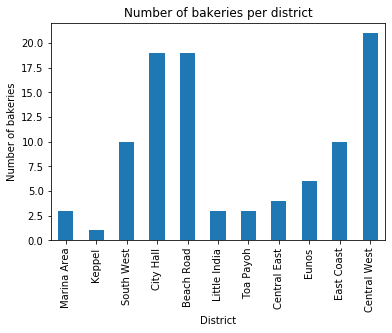

In [39]:
# Plot bar chart with number of bakeries per district

bakery_count=location_df[["District","Count"]]
bakery_count.set_index('District', inplace=True)

plot1=bakery_count["Count"].plot.bar(x="District", title="Number of bakeries per district")
plot1.set_ylabel("Number of bakeries")

# Create map visualization of number of bakeries per district

In [27]:
import folium
latitude  = location_df.iloc[0]["Latitude"]
longitude = location_df.iloc[0]["Longitude"]

# create map using latitude and longitude values of 1st venue
map_singapore = folium.Map(location=[latitude, longitude], zoom_start=12)

In [29]:
# add markers to map. Size of markers indicates the number of bakeries in that area

for lat, lng, label, cnt in zip(location_df['Latitude'], location_df['Longitude'], location_df['District'], location_df['Count']):
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5+cnt,
        popup=label,
        color="blue",
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_singapore) 
    
map_singapore

# Get number of likes per venue/district

In [30]:
#Get number of likes for all venues IDs

def getLikes(venue_ids):
    like_list=[]
    print("Getting likes...")
    for venue_id in venue_ids: 
        url = 'https://api.foursquare.com/v2/venues/{}/likes?&client_id={}&client_secret={}&v={}'.format(
            venue_id,
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            )
        results = requests.get(url)
        like = json.loads(results.text)["response"]["likes"]["count"]
        like_list.append([venue_id, like])
    like_df = pd.DataFrame(like_list)
    like_df.columns = ['id','likes']
    return(like_df)

In [31]:
venues=Singapore_bakeries["id"].values
like_df=getLikes(venues)
like_df.head()

Getting likes...


,id,likes
0,573dc658498ecf83760c0610,1
1,4db530e50cb6729b6aa09178,0
2,50e165e6e4b0929c2c346a12,0
3,4eb909b06c2590eb898d78e9,0
4,50952480e4b053f9fb7325b7,3


In [32]:
#add_likes=pd.merge(Singapore_bakeries,like_df,on="id")
#add_likes.head()
Singapore_bakeries=pd.merge(Singapore_bakeries,like_df,on="id")
Singapore_bakeries.head()

,District,Neighborhood Latitude,Neighborhood Longitude,id,Venue,Venue Latitude,Venue Longitude,Venue Category,likes
0,Marina Area,1.287468,103.849361,573dc658498ecf83760c0610,Maison Kayser Cafe,1.285593,103.849466,Bakery,1
1,Marina Area,1.287468,103.849361,4db530e50cb6729b6aa09178,The Sky Of Aika,1.288951,103.849345,Bakery,0
2,Marina Area,1.287468,103.849361,50e165e6e4b0929c2c346a12,Wonder Buns,1.286116,103.848927,Bakery,0
3,Keppel,1.274836,103.829539,4eb909b06c2590eb898d78e9,Asian Bakes,1.276454,103.828924,Bakery,0
4,South West,1.307085,103.790579,50952480e4b053f9fb7325b7,Bakery Cuisine @ Buona Vista Xchange,1.306952,103.789623,Bakery,3


In [33]:
# Create df with venues that have at least 1 Like

venues_with_likes=Singapore_bakeries[Singapore_bakeries["likes"]>0]
venues_with_likes

,District,Neighborhood Latitude,Neighborhood Longitude,id,Venue,Venue Latitude,Venue Longitude,Venue Category,likes
0,Marina Area,1.287468,103.849361,573dc658498ecf83760c0610,Maison Kayser Cafe,1.285593,103.849466,Bakery,1
4,South West,1.307085,103.790579,50952480e4b053f9fb7325b7,Bakery Cuisine @ Buona Vista Xchange,1.306952,103.789623,Bakery,3
5,South West,1.307085,103.790579,5066ef13e4b0cdb22fb8c77c,Four Leaves,1.306264,103.789379,Bakery,2
6,South West,1.307085,103.790579,5264dfd711d2f51f6cb8258c,Artisan Boulangerie Co.,1.306046,103.791171,Bakery,14
7,South West,1.307085,103.790579,4ff7ec69067d7fbeb9eac117,Simply Bread Bakery,1.306605,103.791254,Bakery,2
8,South West,1.307085,103.790579,52de1132498e1a1f9ba88ec1,Twelve Cupcakes,1.306476,103.789283,Cupcake Shop,3
9,South West,1.307085,103.790579,5bc94f77dd8442002c695fa3,Cedele,1.306003,103.791306,Bakery,1
10,South West,1.307085,103.790579,4f84f43ae4b0ab310a5797c8,Jia Jia Pancake,1.307518,103.792413,Bakery,3
11,South West,1.307085,103.790579,5544922c498ef900ddaa72bf,Baker Talent,1.306480,103.790788,Bakery,2
13,South West,1.307085,103.790579,50a5c728e4b00184ad403922,iBake,1.306327,103.789249,Bakery,12


In [89]:
#Get some stats from likes

max_likes=venues_with_likes.loc[venues_with_likes["likes"].idxmax()]
print("Bakery with most likes: {} with {} likes".format(max_likes["Venue"],max_likes["likes"]))
print("The mean of all likes is {:.2f}".format(venues_with_likes["likes"].mean()))

Bakery with most likes: Tiong Bahru Bakery with 193 likes
The mean of all likes is 10.08


In [34]:
# Group number of likes per district
district_likes=venues_with_likes.groupby(["District"])['likes'].sum().to_frame()
district_likes

,likes
District,
Beach Road,12
Central East,1
Central West,22
City Hall,245
East Coast,133
Eunos,1
Little India,10
Marina Area,1
South West,42


Text(0, 0.5, 'Total number of likes')

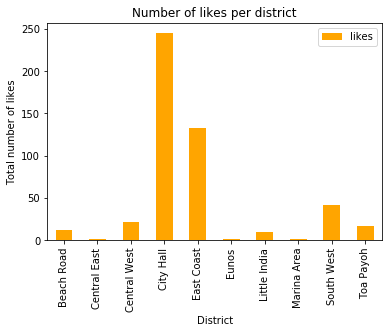

In [47]:
# Plot bar chart with number of likes per district

plot2=district_likes.plot.bar(color='orange',title="Number of likes per district")
plot2.set_ylabel("Total number of likes")

# Bar charts of combined data points 
### Non-normalized and normalized

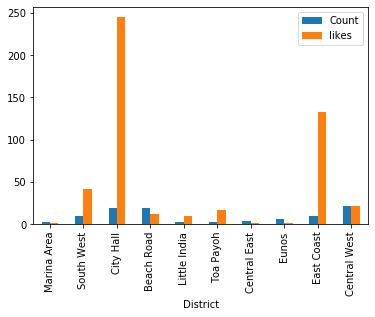

In [36]:
# Create and plot combined df with bakery and likes count per district

merged=pd.merge(bakery_count,district_likes, left_index=True, right_index=True)
merged.plot.bar()

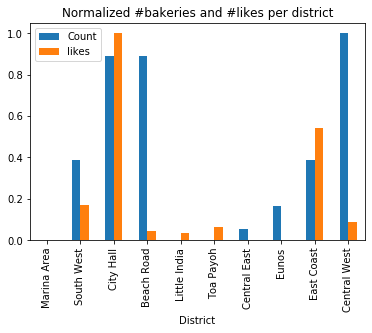

In [44]:
# Min-Max normalization on columns to create better visual
# Plot the normalized values per district

norm=(merged-merged.min())/(merged.max()-merged.min())
norm.plot.bar(title="Normalized #bakeries and #likes per district")

# Conclusion
Using free data sources and some basic analysis, it can be concluded that opening a new restaurant in the neighbourhood of City Hall might have a good chance of being successful. With 19 bakeries and the highest score of 245 likes, this area is a very popular area for having breakfast. 

At the other hand, the Central West district also has many bakeries, but none of them very popular. It may be interesting to check out if opening a success formula in this part of Singapore may even be more beneficial than opening a bakery near City Hall that needs to compete with a very popular existing bakery venue.

As this study only considered a few data points (number of bakeries per district and number of likes per district), further analysis should be done to include other data sources such as type of bakery, unique visitors per time period, venue tips, average cost of a meal, and more.